<a href="https://colab.research.google.com/github/andreacharlota/Query-Visualization-Online-Game/blob/main/Query_Visualization_DezzDryth_Online_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop2.7.tgz  
!tar -xvf spark-3.2.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.2.0-bin-hadoop2.7/
spark-3.2.0-bin-hadoop2.7/NOTICE
spark-3.2.0-bin-hadoop2.7/kubernetes/
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/python_executable_check.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/autoscale.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/worker_memory_check.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/py_container_checks.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/decommissioning.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/pyfiles.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/decommissioning_cleanup.py
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/decom.sh
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/
spark-3.2.0-bin-hadoop2.7/kubernetes/docker

In [16]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

In [17]:
spark.read.csv("MsNPC.csv",header=True).createOrReplaceTempView("npcs")
spark.read.csv("MsPlayer.csv",header=True).createOrReplaceTempView("players")
spark.read.csv("MsWeapon.csv",header=True).createOrReplaceTempView("weapons")
spark.read.csv("MsWeaponType.csv",header=True).createOrReplaceTempView("weapon_types")
spark.read.csv("TransactionDetail.csv",header=True).createOrReplaceTempView("transaction_details")
spark.read.csv("TransactionHeader.csv",header=True).createOrReplaceTempView("transaction_headers")

spark.sql("select * from players").show()

+--------+-----------------+------------+----------+
|PlayerId|       PlayerName|PlayerGender| PlayerDOB|
+--------+-----------------+------------+----------+
|       1|      Janos Hasel|        Male|2001-12-25|
|       2|      Barty Kayne|        Male|1999-05-17|
|       3|     Pattin Maron|        Male|2000-02-25|
|       4|  Steffane Gandar|      Female|2001-01-06|
|       5|  Isobel Ferryman|      Female|1999-03-19|
|       6|Dorothea Nockells|      Female|1996-06-14|
|       7|    Humphrey Ivan|        Male|1998-12-04|
|       8|     Nikki Lambie|        Male|1995-09-07|
|       9|  Karney Da Costa|        Male|2000-01-12|
|      10|     Weylin Jakel|        Male|1998-06-27|
|      11|  Keriann Arnolds|      Female|2000-02-16|
|      12|        Liz Acock|      Female|1997-03-30|
|      13|  Emmeline Ferreo|      Female|1997-03-06|
|      14|     Billye Dudin|      Female|1997-12-11|
|      15|    Jobie Volkers|      Female|1999-08-06|
|      16|   Vernice Antrum|      Female|1995-

,weapontypename,revenue
0,Scythe,22833000.0
1,Sword,24300000.0
2,Flail,25748000.0
3,Bow,26484000.0
4,Axe,36184000.0


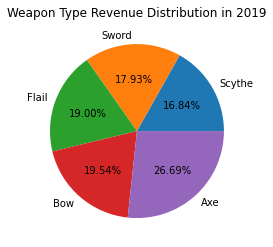

In [18]:
#a.	Show the percentage of weapon type sold for weapon type that is sold in 2019 
# using pie plot.

data = spark.sql("""
    select wt.weapontypename, sum(w.weaponprice * td.quantity) as revenue
    from weapon_types wt
    join weapons w on wt.weapontypeid = w.weapontypeid
    join transaction_details td on w.weaponid = td.weaponid
    join transaction_headers th on td.transactionid = th.transactionid
    where year(th.transactiondate) = 2019
    group by wt.weapontypeid, weapontypename
    order by revenue
""").toPandas()

display(data)

plt.pie(data["revenue"], labels=data["weapontypename"], autopct="%.2f%%")
plt.title("Weapon Type Revenue Distribution in 2019")
plt.show()


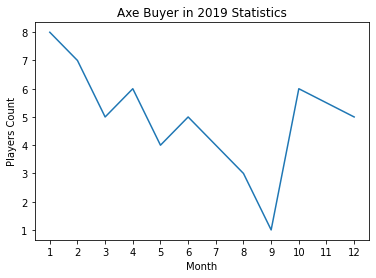

In [19]:
#b.	Show the total number of players who bought axe weapon type per month in 2019 
#using line plot. Multiple transaction within the same month will be counted as 1.

data = spark.sql("""
    select count(distinct th.playerid) as total,month(th.transactiondate) as month
    from transaction_headers th
    join transaction_details td on th.transactionid = td.transactionid
    join weapons w on td.weaponid = w.weaponid
    join weapon_types wt on w.weapontypeid = wt.weapontypeid
    where year(th.transactiondate) = 2019 and
    wt.weapontypename = 'Axe'
    group by month(th.transactiondate)
    order by month
""").toPandas()

plt.plot(data["month"], data["total"])
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Players Count")
plt.title("Axe Buyer in 2019 Statistics")
plt.show()

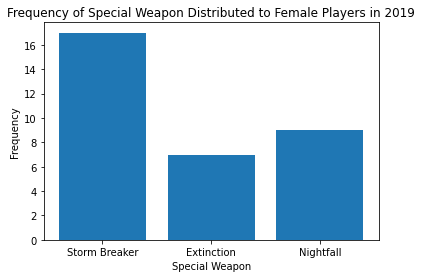

In [20]:
# c.	Show the frequency of special weapon being distributed to female players in 2019 
# using bar plot. The player will receive special weapon if their monthly spending 
# reached this following condition: 
# Special Weapon	Monthly Spending
# Storm Breaker	1000000 - 1499999
# Nightfall	    1500000 – 1999999
# Extinction	  > 2000000

data = spark.sql("""
select specialweapon, count(*) as frequency
from(
    select
    p.playerid, sum(w.weaponprice * td.quantity) as spending,
   
    case
      when sum(w.weaponprice * td.quantity) between 1000000 and 1499999 then 'Storm Breaker'
      when sum(w.weaponprice * td.quantity) between 1500000 and 1999999 then 'Nightfall'
      when sum(w.weaponprice * td.quantity) > 2000000 then 'Extinction'
    end as specialweapon 
  
    from players p 
    join transaction_headers th on p.playerid = th.playerid
    join transaction_details td on th.transactionid = td.transactionid
    join weapons w on td.weaponid = w.weaponid
    where p.playergender = 'Female' and
    year (th.transactiondate) = 2019
    group by p.playerid, month(th.transactiondate)
)
    where specialweapon is not null
    group by specialweapon
""").toPandas()

plt.bar(data["specialweapon"], data["frequency"])
plt.title("Frequency of Special Weapon Distributed to Female Players in 2019")
plt.xlabel("Special Weapon")
plt.ylabel("Frequency")
plt.show()


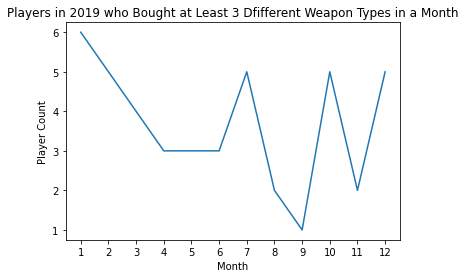

In [21]:
# d. Show total number of players per month in 2019 who bought at least 3 different 
# weapon type in a month using line plot.

data = spark.sql("""
   select month, count(playerid) as total
   from(
      select 
      th.playerid,
      month(th.transactiondate) as month
      from transaction_headers th
      join transaction_details td on th.transactionid = td.transactionid
      join weapons w on td.weaponid = w.weaponid
      where year(th.transactiondate) = 2019
      group by th.playerid, month
      having count(distinct w.weapontypeid) >= 3
   )
   group by month
   order by month
""").toPandas()

plt.plot(data["month"], data["total"])
plt.title("Players in 2019 who Bought at Least 3 Dfifferent Weapon Types in a Month")
plt.xticks(range (1,13))
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.show()

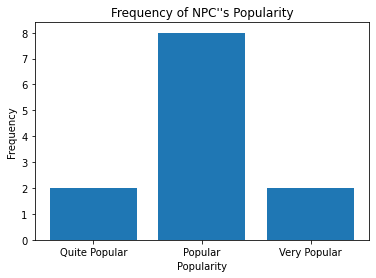

In [39]:
# e. Show the frequency of NPC's popularity who has done at least transaction with 5 
# different player using bar plot. The popularity is determined based on the total income 
# made by the NPC as follows:
# Popularity	Total Income
# Very Popular	>= 15,000,000
# Popular	>= 7,500,000 – 14,999,999
# Quite Popular	>= 2,500,000 – 7,499,999
# Not Popular	< 2,500,000

data = spark.sql("""
      select popularity, count(*) as count
      from (
        select n.npcid,

      case
        when sum(td.quantity * w.weaponprice) >= 15000000 then 'Very Popular'
        when sum(td.quantity * w.weaponprice) between 7500000 and 14999999 then 'Popular'
        when sum(td.quantity * w.weaponprice) between 2500000 and 7999999 then 'Quite Popular'
        when sum(td.quantity * w.weaponprice) < 2500000 then 'Not Popular'
      end as popularity

      from npcs n
      join transaction_headers th on n.npcid = th.npcid
      join transaction_details td on th.transactionid = td.transactionid
      join weapons w on td.weaponid = w.weaponid
      group by n.npcid
      having count(distinct th.playerid) >= 5
      )
      group by popularity
""").toPandas()

plt.bar(data["popularity"], data["count"])
plt.title("Frequency of NPC''s Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()